Necessary imports

In [111]:
from pathlib import Path
import os, sys

import napari
import pandas as pd

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc.core.file_io import (read_czi_image,
                                        export_inferred_organelle,
                                        import_inferred_organelle,
                                        export_tiff,
                                        list_image_files)
from infer_subc.constants import (TEST_IMG_N,
                                   NUC_CH ,
                                    LYSO_CH ,
                                    MITO_CH ,
                                    GOLGI_CH ,
                                    PEROX_CH ,
                                    ER_CH ,
                                    LD_CH ,
                                    RESIDUAL_CH)
from skimage.measure import regionprops
from infer_subc.core.img import *
from infer_subc.utils.stats import *
from infer_subc.utils.stats import _assert_uint16_labels, _my_props_to_dict
from infer_subc.utils.stats_helpers import *
from napari.utils.notebook_display import nbscreenshot
from skimage.measure import _moments
from infer_subc.organelles import *
from skimage.measure._regionprops import _RegionProperties
from skimage.measure._moments import inertia_tensor_eigvals
from skimage import draw
import time
import math
from scipy import ndimage
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# SCALE AND SPACING NOTEBOOK 📏

══════════════════════════════════════════════════════════════════════════════════════════════════

## Background
With the current workflow, we have been able to extract an abundance of data regarding the cells from the .czi images. However, with the data being anisotropic, what do these numbers mean in the real world? Better yet, is there a way to interpret the data in real-world measurements? Luckily enough, with scikit-image version 0.20.0, there is. The new "spacing" parameter for the regionprops function allows for the measurements to be collected under a specified scale. This is ideal since the metadata from the .czi images contains the real-world scale in microns (micrometers). The terms scaling and spacing are nearly interchangeable. The use of one term over the other is simply due to the function it is used in.

The projection stats functions will also be updated to include an option that allows for an option to either keep the nucleus projection as the first bin or to build the bins around the nucleus. This is covered in-depth in 11_2_projection_stats_notebook

### This will be done in the following steps (Assuming the segmentation has already been completed)
- Choose the test cell
- Get the masks
- Establish the inputs
- Create and Modify the functions
- Run scaled and unscaled (control) version of `make_organelle_stat_tables`
- Dump the stats tables
- Compare / Contrast the data

# CHOOSE THE TEST CELL

In [130]:
# this will be the example image for testing the pipeline below
test_img_n = 1

# build the datapath
# all the imaging data goes here.
data_root_path = Path("C:/Users/redre/Documents/CohenLab/MSI-3D-analysis/20230606_test_files_practice_analysis")

# linearly unmixed ".czi" files are here
in_data_path = data_root_path / "test_files"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

# save output ".tiff" files here
out_data_path = data_root_path / "20230606_out"

if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

# organelle to use as main example
ex_org = LYSO_CH


In [131]:
# This is the name of the image we will test the data on
test_img_name.stem

'24hrs-Ctrl +oleicAcid 50uM_3_Unmixing'

In [132]:
# establishing the image data and the meta dictionary
img_data,meta_dict = read_czi_image(test_img_name)

c:\Users\redre\anaconda3\envs\infer-subc-quan\lib\site-packages\ome_types\_convenience.py:112: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


This is where the scale is collected

In [133]:
# Extracting numbers from the meta data, including the scale :)
channel_names = meta_dict['name']
channel_axis = meta_dict['channel_axis']

# This gets the image as an aicsimage type, I have not used that yet
img = meta_dict['metadata']['aicsimage']

scale = meta_dict['scale']

source_file = meta_dict['file_name']


In [134]:
viewer_tc = napari.Viewer(title='Test Cell',ndisplay=3)

c:\Users\redre\anaconda3\envs\infer-subc-quan\lib\site-packages\napari\layers\base\base.py:747: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(


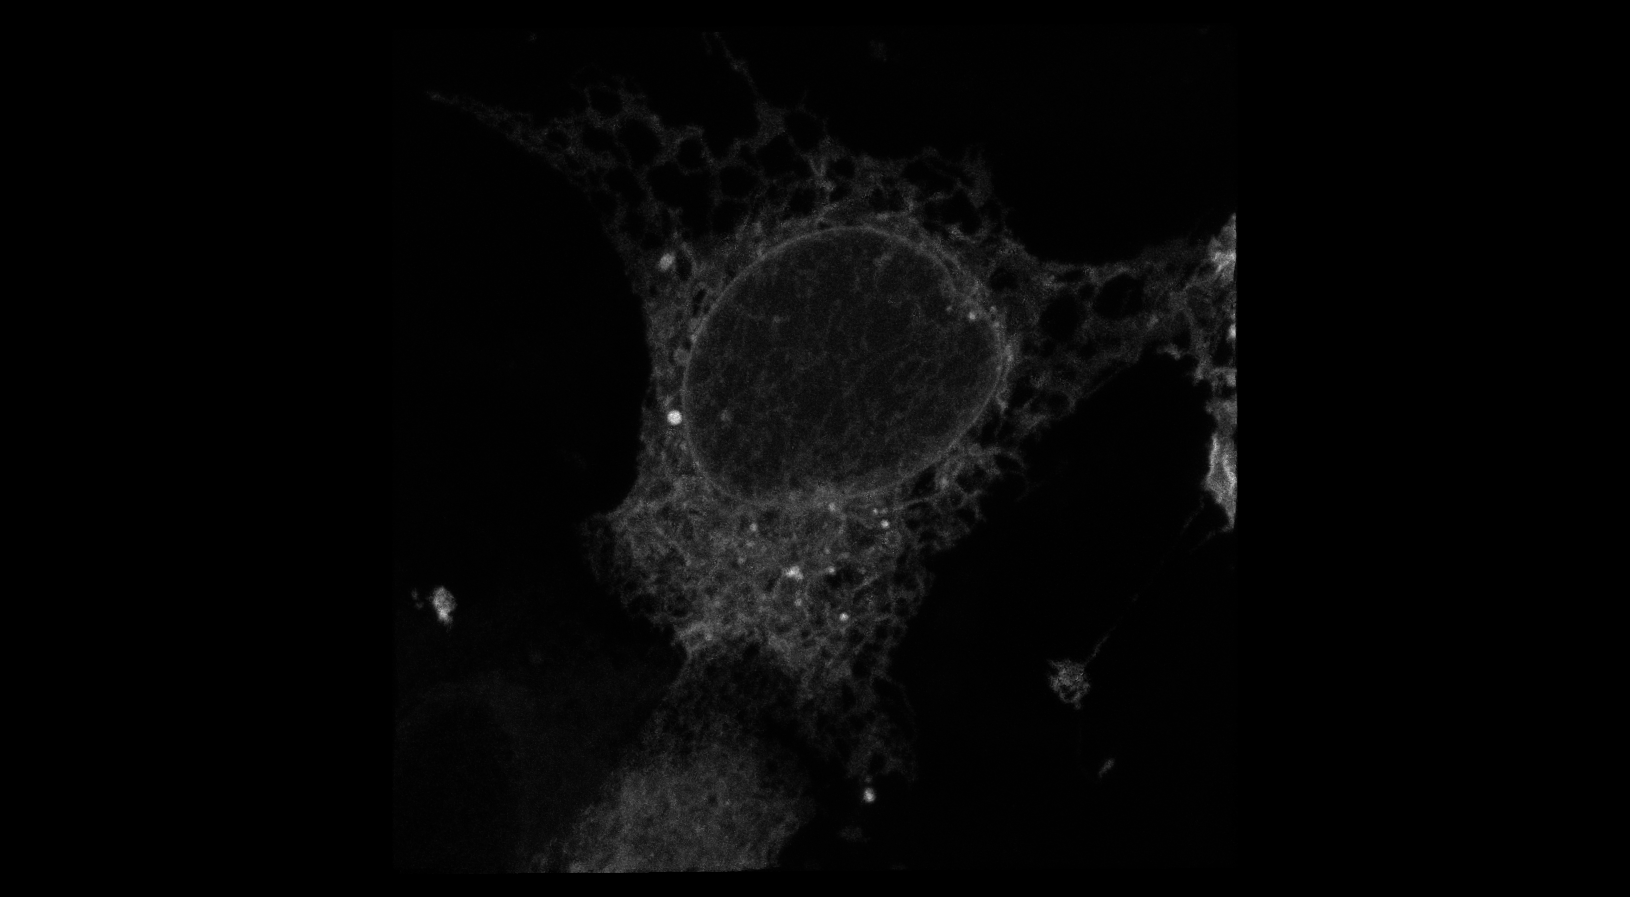

In [135]:
# This is the cell
viewer_tc.add_image((img_data[ER_CH]), scale=scale, rotate = (5,-5,0))
nbscreenshot(viewer_tc, canvas_only = True)


This is the cell in the ER channel, the next image will be the cell split into individual channels.

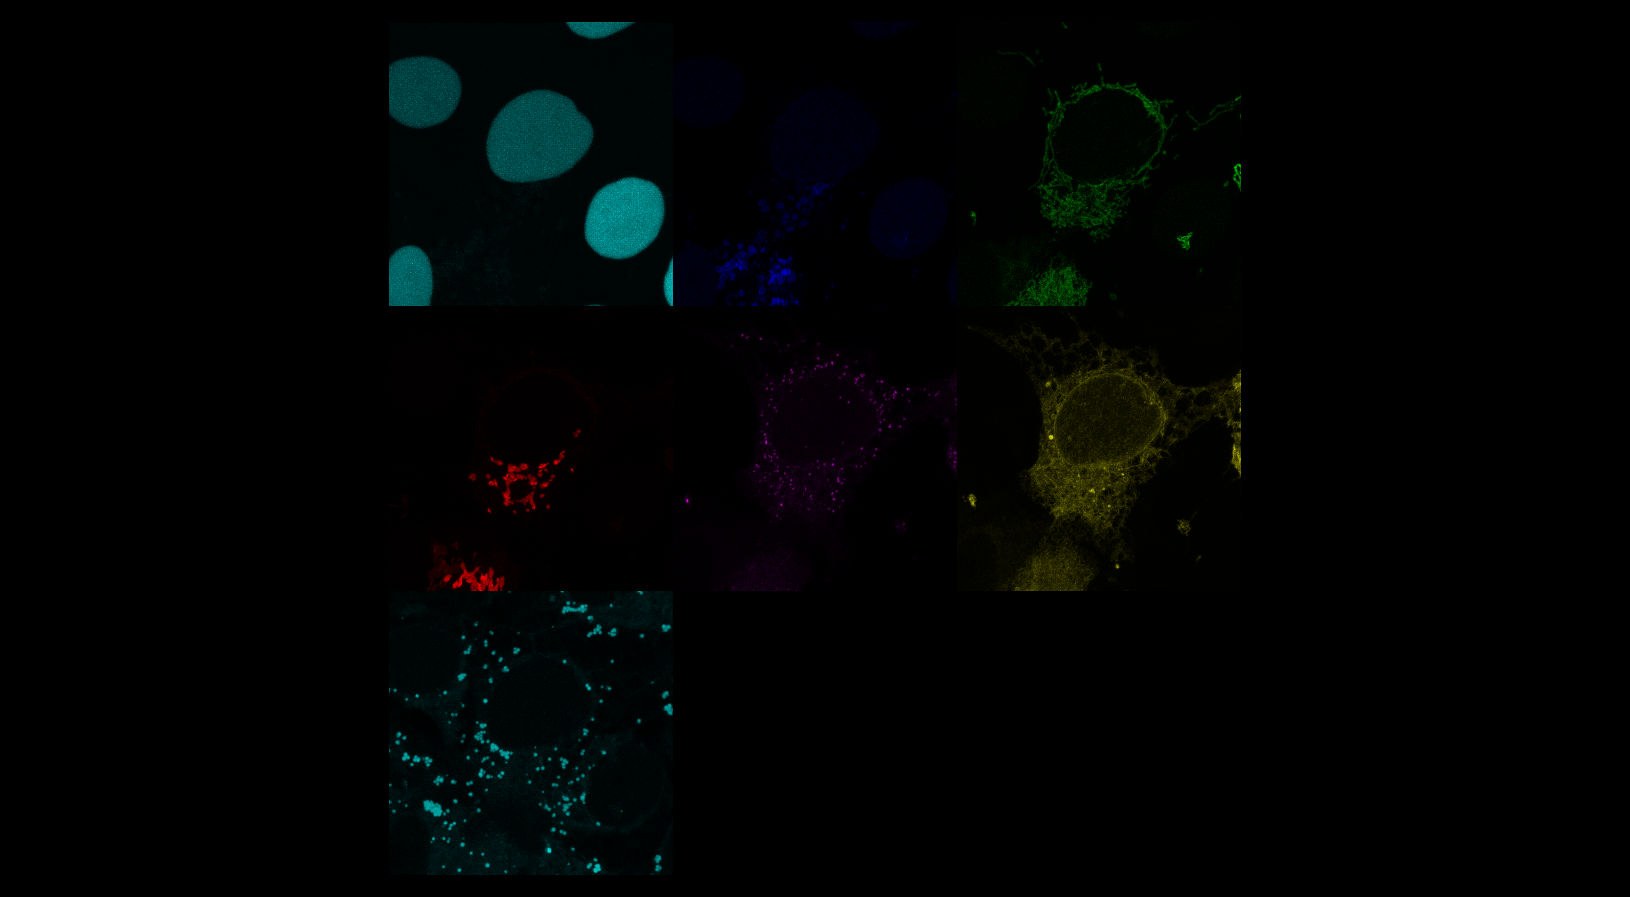

In [136]:
viewer_tc.layers.clear()
viewer_tc.grid.enabled = True
# The last channel was omitted because it has the residual signal
viewer_tc.add_image(img_data[0:-1][::-1], scale=scale, channel_axis=channel_axis)
viewer_tc.reset_view()
nbscreenshot(viewer_tc, canvas_only = True)

# GET THE MASKS

In [137]:
# The phrase added in the napari workflow
phrase = "20230606_testnrm"

In [138]:
out_data_path

WindowsPath('C:/Users/redre/Documents/CohenLab/MSI-3D-analysis/20230606_test_files_practice_analysis/20230606_out')

In [139]:
# for the cellmask and cytoplasm objects
cell_object = read_tiff_image(f'{out_data_path}/{test_img_name.stem}-{phrase}_cell.tiff')
cyto_object = read_tiff_image(f'{out_data_path}/{test_img_name.stem}-{phrase}_cyto.tiff')

In [140]:
# For the organelles
org_masks = []
org_names = []
for organelle in organelle_to_colname:
    if organelle != "cell" and organelle != "cyto":
        try:
            org_masks.append(read_tiff_image(f'{out_data_path}/{test_img_name.stem}-{phrase}_{organelle}.tiff'))
            org_names.append(organelle)
            print(f'{organelle} had a mask object in {test_img_name.stem}')
        except:
            print(f'{organelle} did not have a mask object in {test_img_name.stem}')
    else:
        print(f'{organelle} is not an organelle')


nuc had a mask object in 24hrs-Ctrl +oleicAcid 50uM_3_Unmixing
lyso had a mask object in 24hrs-Ctrl +oleicAcid 50uM_3_Unmixing
mito had a mask object in 24hrs-Ctrl +oleicAcid 50uM_3_Unmixing
golgi had a mask object in 24hrs-Ctrl +oleicAcid 50uM_3_Unmixing
perox had a mask object in 24hrs-Ctrl +oleicAcid 50uM_3_Unmixing
ER had a mask object in 24hrs-Ctrl +oleicAcid 50uM_3_Unmixing
LD had a mask object in 24hrs-Ctrl +oleicAcid 50uM_3_Unmixing
cell is not an organelle
cyto is not an organelle
nucleus did not have a mask object in 24hrs-Ctrl +oleicAcid 50uM_3_Unmixing
nuclei did not have a mask object in 24hrs-Ctrl +oleicAcid 50uM_3_Unmixing


In [141]:
print(org_names)

['nuc', 'lyso', 'mito', 'golgi', 'perox', 'ER', 'LD']


In [142]:
# Establishing the organelle intensities
org_in = img_data[:len(org_names)]

# ESTABLISH THE INPUTS

In [143]:
# These will remain the same throughout all functions

organelle_names = org_names
organelles = org_masks
intensities = org_in
nuclei_object = organelles[NUC_CH]
cellmask_obj = cell_object
organelle_mask = cell_object
out_data_path = out_data_path
source_file = source_file
n_rad_bins = 5
n_zernike = 9

# CREATE AND MODIFY THE FUNCTIONS

`nrm` is the prefix I used to denote my proposed functions or functions containing my proposed changes

## Function Tree
- #### nrm_make_organelle_stat_tables / test_make_organelle_stat_tables
    - ##### nrm_get_summary_stats_3D
        - ###### nrm_surface_area_from_props
        - ###### nrm_minor_axis_length
    - ##### nrm_get_aXb_stats_3D
        - ###### nrm_surface_area_from_props
        - ###### nrm_minor_axis_length
    - ##### nrm_get_radial_stats 
        - ###### nrm_get_radial_distribution
        - ###### nrm_get_zernike_stats
    - ##### nrm_get_depth_stats

- #### test_dump_organelle_summary_tables
    - ##### test_summarize_organelle_stats
        - ###### nrm_create_stats_summary

In [144]:
def nrm_surface_area_from_props(labels, props, spacing):
    """helper function for getting surface area of volumetric segmentation"""

    # Added to for scale implementation, a default value for if there is no scale
    if spacing is None:
        spacing = np.ones(labels.ndim)

    # SurfaceArea
    surface_areas = np.zeros(len(props["label"]))
    # TODO: spacing = [1, 1, 1] # this is where we could deal with anisotropy in Z

    for index, lab in enumerate(props["label"]):
        # this seems less elegant than you might wish, given that regionprops returns a slice,
        # but we need to expand the slice out by one voxel in each direction, or surface area freaks out
        volume = labels[
            max(props["bbox-0"][index] - 1, 0) : min(props["bbox-3"][index] + 1, labels.shape[0]),
            max(props["bbox-1"][index] - 1, 0) : min(props["bbox-4"][index] + 1, labels.shape[1]),
            max(props["bbox-2"][index] - 1, 0) : min(props["bbox-5"][index] + 1, labels.shape[2]),
        ]
        volume = volume == lab
        verts, faces, _normals, _values = marching_cubes(
            volume,
            method="lewiner",
            spacing=spacing,
            level=0,
        )
        surface_areas[index] = mesh_surface_area(verts, faces)

    return surface_areas

In [145]:
def nrm_get_summary_stats_3D(input_labels: np.ndarray, intensity_img, mask: np.ndarray, scale: Union[tuple,None] = None) -> Tuple[Any, Any]:
    """collect volumentric stats from skimage.measure.regionprops
        properties = ["label","max_intensity", "mean_intensity", "min_intensity" ,"area"->"volume" , "equivalent_diameter",
        "centroid", "bbox","euler_number", "extent"
        +   extra_properties = [standard_deviation_intensity]

    Parameters
    ------------
    input_labels:
        a 3d  np.ndarray image of the inferred organelle labels
    intensity_img:
        a 3d np.ndarray image of the florescence intensity
    mask:
        a 3d image containing the cellmask object (mask)

    Returns
    -------------
    pandas dataframe of stats and the regionprops object
    """

    # in case we sent a boolean mask (e.g. cyto, nucleus, cellmask)
    input_labels = _assert_uint16_labels(input_labels)

    # mask
    input_labels = apply_mask(input_labels, mask)

    # start with LABEL
    properties = ["label"]
    # add intensity:
    properties = properties + ["max_intensity", "mean_intensity", "min_intensity"]

    # arguments must be in the specified order, matching regionprops
    def standard_deviation_intensity(region, intensities):
        return np.std(intensities[region])

    extra_properties = [standard_deviation_intensity]

    # add area
    properties = properties + ["area", "equivalent_diameter"]
    #  position:
    properties = properties + ["centroid", "bbox"]  # , 'bbox', 'weighted_centroid']
    # etc
    properties = properties + ["euler_number", "extent"]  # only works for BIG organelles: 'convex_area','solidity',
    # testing nrm
    
    # major and minor axis will be added in the next notebook

    rp = regionprops(input_labels, intensity_image=intensity_img, extra_properties=extra_properties,spacing=scale)

    props = _my_props_to_dict(
        rp, input_labels, intensity_image=intensity_img, properties=properties, extra_properties=extra_properties
    )

    props["surface_area"] = nrm_surface_area_from_props(input_labels, props, spacing=scale)

    # was added for scale
    if scale is not None:
        props["Scaled"] = "Yes"
        for i,dim in enumerate(scale):
            props[f"scale_dim{i}"] = str(dim)
    else:
        props["Scaled"] = "No"
        
    props_table = pd.DataFrame(props)
    props_table.rename(columns={"area": "volume"}, inplace=True)
    #  # ETC.  skeletonize via cellprofiler /Users/ahenrie/Projects/Imaging/CellProfiler/cellprofiler/modules/morphologicalskeleton.py
    #         if x.volumetric:
    #             y_data = skimage.morphology.skeletonize_3d(x_data)
    # /Users/ahenrie/Projects/Imaging/CellProfiler/cellprofiler/modules/measureobjectskeleton.py

    return props_table, rp

In [146]:
def nrm_get_aXb_stats_3D(a, b, mask, use_shell_a=False, scale: Union[tuple,None] = None):
    """
    collect volumentric stats of `a` intersect `b`
    """
    properties = ["label"]  # our index to organelles
    # add area
    properties = properties + ["area", "equivalent_diameter"]
    #  position:
    properties = properties + ["centroid", "bbox"]  # ,  'weighted_centroid']
    # etc
    properties = properties + ["slice"]

    # in case we sent a boolean mask (e.g. cyto, nucleus, cellmask)
    a = _assert_uint16_labels(a)
    b = _assert_uint16_labels(b)

    if use_shell_a:
        a_int_b = np.logical_and(np.logical_xor(a > 0, binary_erosion(a > 0)), b > 0)
    else:
        a_int_b = np.logical_and(a > 0, b > 0)

    labels = label(apply_mask(a_int_b, mask)).astype("int")

    props = regionprops_table(labels, intensity_image=None, properties=properties, extra_properties=None, spacing=scale)

    props["surface_area"] = nrm_surface_area_from_props(labels, props, spacing=scale)
    
    # there could be a bug here if there are spurious labels in the corners of the slices

    label_a = []
    index_ab = []
    label_b = []
    for index, lab in enumerate(props["label"]):
        # this seems less elegant than you might wish, given that regionprops returns a slice,
        # but we need to expand the slice out by one voxel in each direction, or surface area freaks out
        volume = labels[props["slice"][index]]
        la = a[props["slice"][index]]
        lb = b[props["slice"][index]]
        volume = volume == lab
        la = la[volume]
        lb = lb[volume]

        all_as = np.unique(la[la>0]).tolist()
        all_bs = np.unique(lb[lb>0]).tolist()
        if len(all_as) != 1:
            print(f"we have an error.  as-> {all_as}")
        if len(all_bs) != 1:
            print(f"we have an error.  bs-> {all_bs}")

        label_a.append(all_as[0] )
        label_b.append(all_bs[0] )
        index_ab.append(f"{all_as[0]}_{all_bs[0]}") 


    props["label_a"] = label_a #[np.unique(a[s])[:1].tolist() for s in props["slice"]]
    props["label_b"] = label_b #[np.unique(b[s])[:1].tolist() for s in props["slice"]]
    if scale is not None:
        props["Scaled"] = "Yes"
        for i,dim in enumerate(scale):
            props[f"scale_dim{i}"] = str(dim)
    else:
        props["Scaled"] = "No"
    props_table = pd.DataFrame(props)
    props_table.rename(columns={"area": "volume"}, inplace=True)
    props_table.drop(columns="slice", inplace=True)
    props_table.insert(loc=0,column='label_',value=index_ab)
    props_table.insert(loc=0,column='shell',value=use_shell_a)

    return props_table

In [147]:
def nrm_get_radial_distribution(
        cellmask_proj: np.ndarray,
        org_proj: np.ndarray,
        img_proj: np.ndarray,
        org_name: str,
        nucleus_proj: np.ndarray,
        n_bins: int = 5,
        from_edges: bool = True,
        keep_nuc_bins = True,
        scale: Union[tuple,None] = None 
    ):
    """Perform the radial measurements on the image set

    Parameters
    ------------
    cellmask_proj: np.ndarray,
    org_proj: np.ndarray,
    img_proj: np.ndarray,
    org_name: str,
    nucleus_proj: np.ndarray,
    n_bins: int = 5,
    from_edges: bool = True,
    keep_nuc_bins = True,

    masked

    # params
    #   n_bins .e.g. 6
    #   normalizer - cellmask_voxels, organelle_voxels, cellmask_and_organelle_voxels
    #   from_edges = True


    Returns
    -------------
    returns one statistics table + bin_indexes image array
    """

    # other params
    bin_count = n_bins if n_bins is not None else 5
    nobjects = 1
    scale_bins = True
    ### I am removing this as a statement thus making it an option to omit or include the nucleus, default is true 
    # keep_nuc_bins = True
    center_on_nuc = False # choosing the edge of the nuclei or the center as the center to propogate from

    center_objects = nucleus_proj>0 

    # labels = label(cellmask_proj>0) #extent as 0,1 rather than bool

    # labels = np.zeros_like(cellmask_proj)
    # labels[labels>0]=1   

    labels = (cellmask_proj>0).astype(np.uint16)

    ### an if statement as part as the option to omit the nucleus 
    if not keep_nuc_bins:
        labels[nucleus_proj] = 0

    ################   ################
    ## define masks for computing distances
    ################   ################
    normalized_distance, good_mask, i_center, j_center = get_normalized_distance_and_mask(labels, center_objects, center_on_nuc, keep_nuc_bins)
    
    if normalized_distance is None:
        print('WTF!!  normailzed_distance returned wrong')

    ################   ################
    ## get histograms
    ################   ################
    ngood_pixels = np.sum(good_mask)
    good_labels = labels[good_mask]

    # protect against None normaized_distances
    if keep_nuc_bins:
        # For the exterior bins
        bin_indexes = ((normalized_distance * (bin_count - 1)) + 1).astype(int)
        bin_indexes[~good_mask] = 0
        # For the nucleus bin
        bin_indexes[center_objects] = 0
    else:
        bin_indexes = (normalized_distance * (bin_count)).astype(int)
    
    bin_indexes[bin_indexes > bin_count] = bin_count # shouldn't do anything

    #                 (    i          ,         j              )
    labels_and_bins = (good_labels - 1, bin_indexes[good_mask])

    #                coo_matrix( (             data,             (i, j)    ), shape=                      )
    histogram_cmsk = coo_matrix( (cellmask_proj[good_mask], labels_and_bins), shape=(nobjects, bin_count) ).toarray()
    histogram_org = coo_matrix(  (org_proj[good_mask],      labels_and_bins), shape=(nobjects, bin_count) ).toarray()
    histogram_img = coo_matrix(  (img_proj[good_mask],      labels_and_bins), shape=(nobjects, bin_count) ).toarray()

    if keep_nuc_bins:
        # For the exterior bins
        bin_indexes = ((normalized_distance * (bin_count - 1)) + 1).astype(int)
        bin_indexes[~good_mask] = 0
        # For the nucleus bin
        bin_indexes[center_objects] = 0
    else:
        bin_indexes = (normalized_distance * (bin_count)).astype(int)

    sum_by_object_cmsk = np.sum(histogram_cmsk, 1) # flattened cellmask voxel count
    sum_by_object_org = np.sum(histogram_org, 1)  # organelle voxel count
    sum_by_object_img = np.sum(histogram_img, 1)  # image intensity projection

    # DEPRICATE: since we are NOT computing object_i by object_i (individual organelle labels)
    # sum_by_object_per_bin = np.dstack([sum_by_object] * (bin_count + 1))[0]
    # fraction_at_distance = histogram / sum_by_object_per_bin

    # number of bins.
    number_at_distance = coo_matrix(( np.ones(ngood_pixels), labels_and_bins), (nobjects, bin_count)).toarray()

    # sicne we aren't breaking objects apart this is just ngood_pixels

    sum_by_object = np.sum(number_at_distance, 1)

    sum_by_object_per_bin = np.dstack([sum_by_object] * (bin_count))[0]
    fraction_at_bin = number_at_distance / sum_by_object_per_bin # sums to 1.0

    # object_mask = number_at_distance > 0
    # DEPRICATE:# not doing over multiple objects so don't need object mask.. or fractionals
    # mean_pixel_fraction = fraction_at_distance / ( fraction_at_bin + np.finfo(float).eps )
    # masked_fraction_at_distance = np.ma.masked_array( fraction_at_distance, ~object_mask )
    # masked_mean_pixel_fraction = np.ma.masked_array(mean_pixel_fraction, ~object_mask)

    ################   ################
    ## collect Anisotropy calculation.  + summarize
    ################   ################
    # Split each cell into eight wedges, then compute coefficient of variation of the wedges' mean intensities
    # in each ring. Compute each pixel's delta from the center object's centroid
    i, j = np.mgrid[0 : labels.shape[0], 0 : labels.shape[1]]
    imask = i[good_mask] > i_center[good_mask]
    jmask = j[good_mask] > j_center[good_mask]
    absmask = abs(i[good_mask] - i_center[good_mask]) > abs(
        j[good_mask] - j_center[good_mask]
    )
    radial_index = (
        imask.astype(int) + jmask.astype(int) * 2 + absmask.astype(int) * 4
    )

    # return radial_index, labels, good_mask, bin_indexes
    statistics = []
    stat_names =[]
    cv_cmsk = []
    cv_obj = []
    cv_img = []
    # collect the numbers from each "bin"
    for bin in range(bin_count):
        bin_mask = good_mask & (bin_indexes == bin)
        bin_pixels = np.sum(bin_mask)

        bin_labels = labels[bin_mask]

        bin_radial_index = radial_index[bin_indexes[good_mask] == bin]
        labels_and_radii = (bin_labels - 1, bin_radial_index)
        pixel_count = coo_matrix( (np.ones(bin_pixels), labels_and_radii), (nobjects, 8) ).toarray()

        radial_counts_cmsk = coo_matrix( (cellmask_proj[bin_mask], labels_and_radii), (nobjects, 8) ).toarray()
        radial_counts = coo_matrix( (org_proj[bin_mask], labels_and_radii), (nobjects, 8) ).toarray()
        radial_values = coo_matrix( (img_proj[bin_mask], labels_and_radii), (nobjects, 8) ).toarray()

        # we might need the masked arrays for some organelles... but I think not. keeping for now
        mask = pixel_count == 0

        radial_means_cmsk = np.ma.masked_array(radial_counts_cmsk / pixel_count, mask)
        radial_cv_cmsk = np.std(radial_means_cmsk, 1) / np.mean(radial_means_cmsk, 1)
        radial_cv_cmsk[np.sum(~mask, 1) == 0] = 0
        radial_cv_cmsk.mask = np.sum(~mask, 1) == 0


        radial_means_obj = np.ma.masked_array(radial_counts / pixel_count, mask)
        radial_cv_obj = np.std(radial_means_obj, 1) / np.mean(radial_means_obj, 1)
        radial_cv_obj[np.sum(~mask, 1) == 0] = 0
        radial_cv_obj.mask = np.sum(~mask, 1) == 0

        radial_means_img = np.ma.masked_array(radial_values / pixel_count, mask)
        radial_cv_img = np.std(radial_means_img, 1) / np.mean(radial_means_img, 1)
        radial_cv_img[np.sum(~mask, 1) == 0] = 0
        radial_cv_img.mask = np.sum(~mask, 1) == 0

        if keep_nuc_bins:
            bin_name = str(f'bin_{bin})') if bin > 0 else "nuc_bin"
        else: 
            bin_name = str(f'bin_{bin})')
        # # there's gotta be a better way to collect this stuff together... pandas?
        # statistics += [
        #     (   bin_name,
        #         # np.mean(number_at_distance[:, bin]), 
        #         # np.mean(histogram_cmsk[:, bin]), 
        #         # np.mean(histogram_org[:, bin]), 
        #         # np.mean(histogram_img[:, bin]), 
        #         np.mean(radial_cv_cmsk) ,
        #         np.mean(radial_cv_obj) ,
        #         np.mean(radial_cv_img) )
        # ]
        stat_names.append(bin_name)
        cv_cmsk.append(float(np.mean(radial_cv_cmsk)))  #convert to float to make importing from csv more straightforward
        cv_obj.append(float(np.mean(radial_cv_obj)))
        cv_img.append(float(np.mean(radial_cv_img))) # fixed the error

    # TODO: fix this grooooos hack
    # col_names=['organelle','mask','bin','n_bins','n_pix','cm_vox_cnt','org_vox_cnt','org_intensity','cm_radial_cv','org_radial_cv','img_radial_cv']
    # stats_dict={'organelle': org_name,
    #             'mask': 'cell',
    #             'radial_n_bins': bin_count,
    #             'radial_bins': [[s[0] for s in statistics]],
    #             'radial_cm_vox_cnt': [histogram_cmsk.squeeze().tolist()],
    #             'radial_org_vox_cnt': [histogram_org.squeeze().tolist()],
    #             'radial_org_intensity': [histogram_img.squeeze().tolist()],
    #             'radial_n_pix': [number_at_distance.squeeze().tolist()],
    #             'radial_cm_cv':[[s[1] for s in statistics]],
    #             'radial_org_cv':[[s[2] for s in statistics]],
    #             'radial_img_cv':[[s[3] for s in statistics]],
    #             }
    
    stats_dict={'organelle': org_name,
                'mask': 'cell',
                'radial_n_bins': bin_count,
                'radial_bins': [stat_names],
                'radial_cm_vox_cnt': [histogram_cmsk.squeeze().tolist()],
                'radial_org_vox_cnt': [histogram_org.squeeze().tolist()],
                'radial_org_intensity': [histogram_img.squeeze().tolist()],
                'radial_n_pix': [number_at_distance.squeeze().tolist()],
                'radial_cm_cv':[cv_cmsk],
                'radial_org_cv':[cv_obj],
                'radial_img_cv':[cv_img],
                }
    # added to implement scale
    if scale is not None:
        stats_dict["Scaled"] = "Yes",
        for i,dim in enumerate(scale):
            stats_dict[f"scale_dim{i}"] = str(dim),
        stats_dict['radial_cm_vol'] = [(histogram_cmsk * np.prod(scale)).squeeze().tolist()],
        stats_dict['radial_org_vol'] = [(histogram_org * np.prod(scale)).squeeze().tolist()],
        stats_dict['radial_n_area'] =  [(number_at_distance * np.prod(scale[1:])).squeeze().tolist()]
    else:
        stats_dict["Scaled"] = "No"



    # stats_tab = pd.DataFrame(statistics,columns=col_names)
    stats_tab = pd.DataFrame(stats_dict)  
    return stats_tab, bin_indexes, normalized_distance, good_mask

In [148]:
def nrm_get_zernike_stats(        
        cellmask_proj: np.ndarray,
        org_proj:np.ndarray,
        img_proj: np.ndarray,
        organelle_name: str,
        nucleus_proj: Union[np.ndarray, None] = None,
        zernike_degree: int = 9):

    """
    
    """

    labels = label(cellmask_proj>0) #extent as 0,1 rather than bool
    zernike_indexes = centrosome.zernike.get_zernike_indexes( zernike_degree + 1)


    z = zernike_polynomial(labels, zernike_indexes)
    
    z_cm = zernicke_stat(cellmask_proj, z)
    z_org = zernicke_stat(org_proj, z)
    z_nuc = zernicke_stat(nucleus_proj, z)
    z_img = zernicke_stat(img_proj, z)


    # nm_labels = [f"{n}_{m}" for (n, m) in (zernike_indexes)
    stats_tab = pd.DataFrame({'organelle':organelle_name,
                                'mask':'cell',
                                'zernike_n':[zernike_indexes[:,0].tolist()],
                                'zernike_m':[zernike_indexes[:,1].tolist()],
                                'zernike_cm_mag':[z_cm[0].tolist()],
                                'zernike_cm_phs':[z_cm[1].tolist()],   
                                'zernike_obj_mag':[z_org[0].tolist()],
                                'zernike_obj_phs':[z_org[1].tolist()],
                                'zernike_nuc_mag':[z_nuc[0].tolist()],
                                'zernike_nuc_phs':[z_nuc[1].tolist()],
                                'zernike_img_mag':[z_img[0].tolist()],
                                'zernike_img_phs':[z_img[1].tolist()]} # 'zernike_img_mag':[z_img[1].tolist()]} error fixed
                                )

    return stats_tab

In [149]:
def nrm_get_radial_stats(        
        cellmask_obj: np.ndarray,
        organelle_mask: np.ndarray,
        organelle_obj:np.ndarray,
        organelle_img: np.ndarray,
        organelle_name: str,
        nuclei_obj: np.ndarray,
        n_rad_bins: Union[int,None] = None,
        n_zernike: Union[int,None] = None,
        keep_nuc_bins: bool = True,
        scale: Union[tuple,None] = None 
        ):

    """
    Params


    Returns
    -----------
    rstats table of radial distributions
    zstats table of zernike magnitudes and phases
    rad_bins image of the rstats bins over the cellmask_obj 

    """


    # flattened
    cellmask_proj = create_masked_Z_projection(cellmask_obj)
    org_proj = create_masked_Z_projection(organelle_obj,organelle_mask.astype(bool))
    img_proj = create_masked_Z_projection(organelle_img,organelle_mask.astype(bool), to_bool=False)

    nucleus_proj = create_masked_Z_projection(nuclei_obj,cellmask_obj.astype(bool))

    # Added to the outputs for visualization purposes

    radial_stats, radial_bin_mask, normalized_distance, good_mask = nrm_get_radial_distribution(cellmask_proj=cellmask_proj, 
                                                            org_proj=org_proj, 
                                                            img_proj=img_proj, 
                                                            org_name=organelle_name, 
                                                            nucleus_proj=nucleus_proj, 
                                                            n_bins=n_rad_bins,
                                                            keep_nuc_bins=keep_nuc_bins,
                                                            scale=scale)
    
    zernike_stats = nrm_get_zernike_stats(
                                      cellmask_proj=cellmask_proj, 
                                      org_proj=org_proj, 
                                      img_proj=img_proj, 
                                      organelle_name=organelle_name, 
                                      nucleus_proj=nucleus_proj, 
                                      zernike_degree = n_zernike)

    return radial_stats,zernike_stats,radial_bin_mask

In [150]:
def nrm_get_depth_stats(        
        cellmask_obj: np.ndarray,
        organelle_mask: np.ndarray,
        organelle_obj:np.ndarray,
        organelle_img: np.ndarray,
        organelle_name: str,
        nuclei_obj: Union[np.ndarray, None],
        scale: Union[tuple,None] = None
        ):
    """

    """

    # flattened
    cellmask_proj = create_masked_depth_projection(cellmask_obj)
    org_proj = create_masked_depth_projection(organelle_obj,organelle_mask.astype(bool))
    img_proj = create_masked_depth_projection(organelle_img,organelle_mask.astype(bool), to_bool=False)
    nucleus_proj = create_masked_depth_projection(nuclei_obj,cellmask_obj.astype(bool)) if nuclei_obj is not None else None
    z_bins = [i for i in range(cellmask_obj.shape[0])]

    # Changed to make scale easier to implement

    data_list = {'organelle':organelle_name,
                            'mask':'cell',
                            'n_z':cellmask_obj.shape[0],
                            'z':[z_bins],
                            'z_cm_vox_cnt':[cellmask_proj.tolist()],
                            'z_org_vox_cnt':[org_proj.tolist()],
                            'z_org_intensity':[img_proj.tolist()],
                            'z_nuc_vox_cnt':[nucleus_proj.tolist()]}
    
    if scale is not None:
        data_list['z_length'] = cellmask_obj.shape[0] * scale[0]
        data_list['z_cm_area'] = [(cellmask_proj * np.prod(scale[1:])).tolist()]
        data_list['z_org_area'] = [(org_proj * np.prod(scale[1:])).tolist()]
        data_list['z_nuc_area'] = [(nucleus_proj * np.prod(scale[1:]).tolist())]
        data_list["Scaled"] = "Yes"
        for i,dim in enumerate(scale):
            data_list[f"scale_dim{i}"] = str(dim)
    else:
        data_list["Scaled"] = "No"

    stats_tab = pd.DataFrame(data_list)
    
    return stats_tab

In [151]:
def nrm_make_organelle_stat_tables(
    organelle_names: List[str],
    organelles: List[np.ndarray],
    intensities: List[np.ndarray],
    nuclei_obj:np.ndarray, 
    cellmask_obj:np.ndarray,
    organelle_mask: np.ndarray, 
    out_data_path: Path, 
    source_file: str,
    n_rad_bins: Union[int,None] = None,
    n_zernike: Union[int,None] = None,
    keep_nuc_bins: bool = True,
    scale: Union[tuple,None] = None,
) -> int:
    """
    get summary and all cross stats between organelles `a` and `b`
    calls `get_summary_stats_3D`

    """
    count = 0
    org_stats_tabs = []
    for j, target in enumerate(organelle_names):
        org_img = intensities[j]        
        org_obj = _assert_uint16_labels(organelles[j])

        # A_stats_tab, rp = get_simple_stats_3D(A,mask)
        a_stats_tab, rp = nrm_get_summary_stats_3D(org_obj, org_img, organelle_mask,scale=scale)
        a_stats_tab.insert(loc=0,column='organelle',value=target )
        a_stats_tab.insert(loc=0,column='ID',value=source_file.stem )

        # add the touches for all other organelles
        # loop over Bs
        merged_tabs = []
        for i, nmi in enumerate(organelle_names):
            if i != j:
                # get overall stats of intersection
                # print(f"  b = {nmi}")
                count += 1
                # add the list of touches
                b = _assert_uint16_labels(organelles[i])

                ov = []
                b_labs = []
                labs = []
                for idx, lab in enumerate(a_stats_tab["label"]):  # loop over A_objects
                    xyz = tuple(rp[idx].coords.T)
                    cmp_org = b[xyz]
                    
                    # total number of overlapping pixels
                    overlap = sum(cmp_org > 0)
                    # overlap?
                    labs_b = cmp_org[cmp_org > 0]
                    b_js = np.unique(labs_b).tolist()

                    # if overlap > 0:
                    labs.append(lab)
                    ov.append(overlap)
                    b_labs.append(b_js)

                cname = organelle_to_colname[nmi]
                # add organelle B columns to A_stats_tab
                a_stats_tab[f"{cname}_overlap"] = ov
                a_stats_tab[f"{cname}_labels"] = b_labs  # might want to make this easier for parsing later

                #####  2  ###########
                # get cross_stats

                cross_tab = nrm_get_aXb_stats_3D(org_obj, b, organelle_mask, scale=scale) 
                shell_cross_tab = nrm_get_aXb_stats_3D(org_obj, b, organelle_mask, use_shell_a=True, scale=scale)
                            
                # cross_tab["organelle_b"]=nmi
                # shell_cross_tab["organelle_b"]=nmi
                #  Merge cross_tabs and shell_cross_tabs 
                # merged_tab = pd.merge(cross_tab,shell_cross_tab, on="label_")
                merged_tab = pd.concat([cross_tab,shell_cross_tab])
                merged_tab.insert(loc=0,column='organelle_b',value=nmi )

                merged_tabs.append( merged_tab )


        #  Now append the 
        # csv_path = out_data_path / f"{source_file.stem}-{target}_shellX{nmi}-stats.csv"
        # e_stats_tab.to_csv(csv_path)
        # stack these tables for each organelle
        crossed_tab = pd.concat(merged_tabs)
        # csv_path = out_data_path / f"{source_file.stem}-{target}X{nmi}-stats.csv"
        # stats_tab.to_csv(csv_path)
        crossed_tab.insert(loc=0,column='organelle',value=target )
        crossed_tab.insert(loc=0,column='ID',value=source_file.stem )

        # now get radial stats
        rad_stats,z_stats, _ = nrm_get_radial_stats(        
                cellmask_obj,
                organelle_mask,
                org_obj,
                org_img,
                target,
                nuclei_obj,
                n_rad_bins,
                n_zernike,
                keep_nuc_bins=keep_nuc_bins,
                scale=scale)

        d_stats = nrm_get_depth_stats(        
                cellmask_obj,
                organelle_mask,
                org_obj,
                org_img,
                target,
                nuclei_obj,
                scale = scale
                )
      
        proj_stats = pd.merge(rad_stats, z_stats,on=["organelle","mask"])
        proj_stats = pd.merge(proj_stats, d_stats,on=["organelle","mask"])
        proj_stats.insert(loc=0,column='ID',value=source_file.stem )


        # write out files... 
        # org_stats_tabs.append(A_stats_tab)
        csv_path = out_data_path / f"{source_file.stem}-{target}-stats.csv"
        a_stats_tab.to_csv(csv_path)

        csv_path = out_data_path / f"{source_file.stem}-{target}-cross-stats.csv"
        crossed_tab.to_csv(csv_path)

        csv_path = out_data_path / f"{source_file.stem}-{target}-proj-stats.csv"
        proj_stats.to_csv(csv_path)

        count += 1

    print(f"dumped {count}x3 organelle stats ({organelle_names}) csvs")
    return count

This is the modified `get_radial_distribution` function, here is what the output looks like when the nucleus is not included.

In [152]:
nstats_tab, nbin_indexes, nnormalized_distance, ngood_mask = nrm_get_radial_distribution(create_masked_Z_projection(cellmask_obj),
                            create_masked_Z_projection(organelles[ex_org],cellmask_obj),
                            create_masked_Z_projection(intensities[ex_org],cellmask_obj,to_bool=False),
                            org_names[ex_org],
                            create_masked_Z_projection(organelles[NUC_CH],cellmask_obj),
                            n_rad_bins,
                            True,
                            keep_nuc_bins= False,
                            scale=scale)

nstats_tab

,organelle,mask,radial_n_bins,radial_bins,radial_cm_vox_cnt,radial_org_vox_cnt,radial_org_intensity,radial_n_pix,radial_cm_cv,radial_org_cv,radial_img_cv,Scaled,scale_dim0,scale_dim1,scale_dim2,radial_cm_vol,radial_org_vol,radial_n_area
0,lyso,cell,5,"[bin_0), bin_1), bin_2), bin_3), bin_4)]","[210248, 272350, 335276, 462693, 633418]","[4656, 4859, 4684, 3816, 7890]","[41185040, 33342681, 31027948, 24568020, 50986...","[13266.0, 17706.0, 23466.0, 36812.0, 75254.0]","[0.01751063176490218, 0.04575816245710623, 0.1...","[1.6859130583461437, 1.8913416172491642, 2.439...","[0.7219616799098043, 1.2850987515392205, 1.556...",Yes,0.3891184878080979,0.07987165184837317,0.07987165184837318,"[[521.9141497938008, 676.074534342023, 832.280...","[[11.557932924165446, 12.061854827860802, 11.6...","[84.63019188139127, 112.9550864956968, 149.700..."


In [153]:
viewer_tc.layers.clear()
viewer_tc.grid.enabled = True
viewer_tc.add_image(ngood_mask)
viewer_tc.add_image(nbin_indexes + ngood_mask, colormap='gist_earth')
viewer_tc.add_image(nnormalized_distance,colormap='gist_earth')
viewer_tc.reset_view()

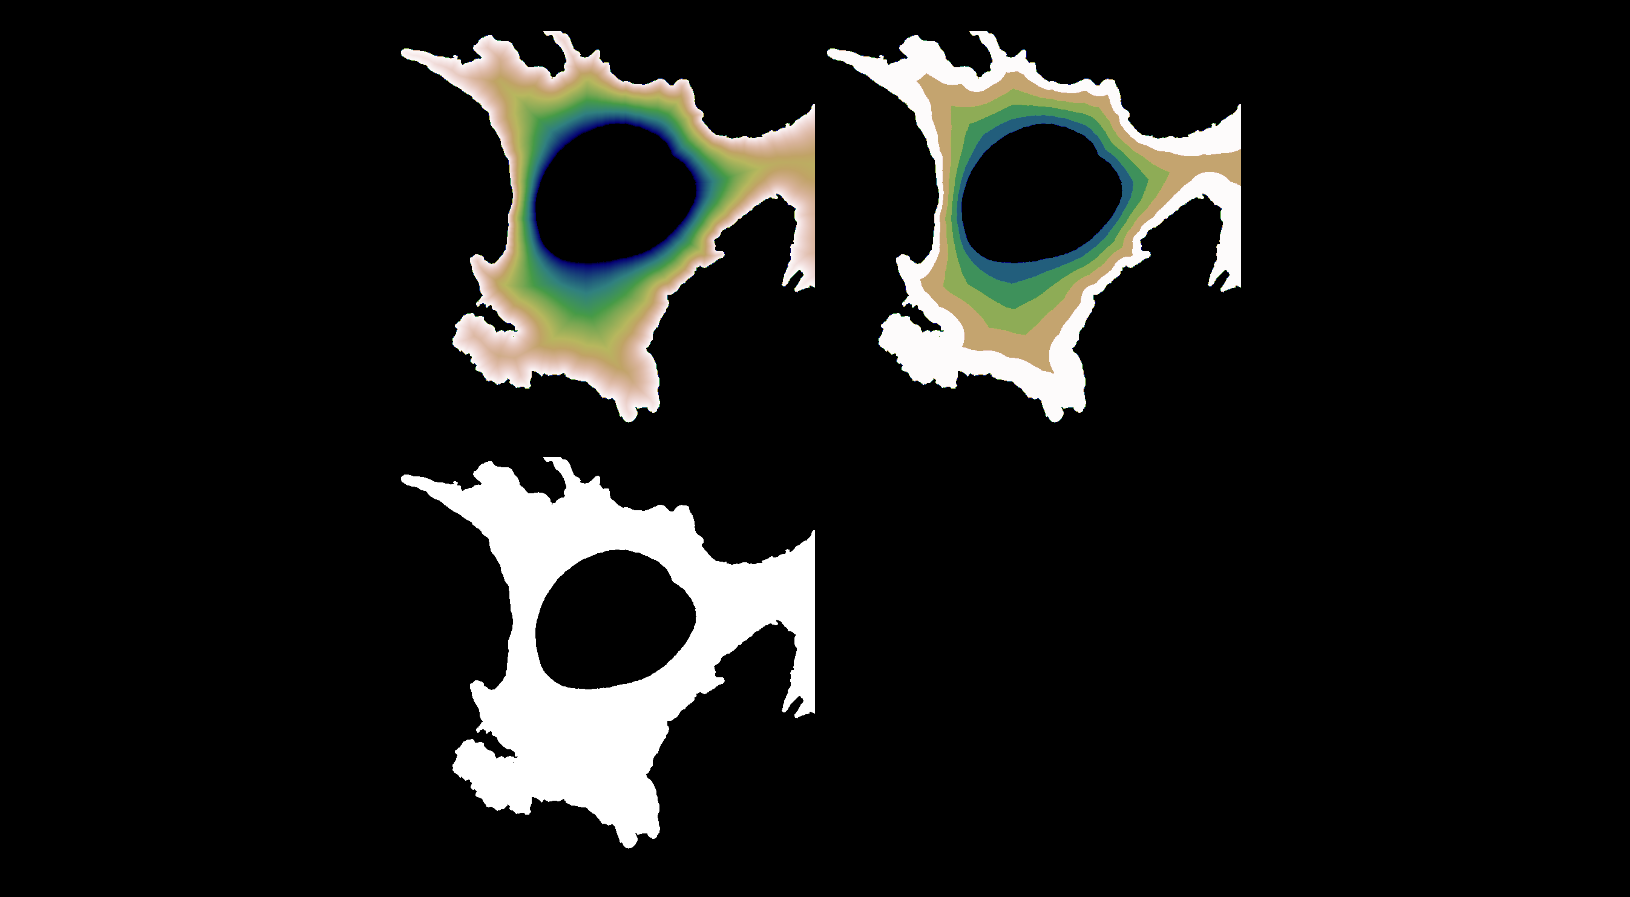

In [154]:
nbscreenshot(viewer_tc, canvas_only= True)

Here are the outputs of the function with the nucleus included, with no scale.

In [155]:
stats_tab, bin_indexes, normalized_distance, good_mask = nrm_get_radial_distribution(create_masked_Z_projection(cellmask_obj),
                            create_masked_Z_projection(organelles[ex_org],cellmask_obj),
                            create_masked_Z_projection(intensities[ex_org],cellmask_obj,to_bool=False),
                            org_names[ex_org],
                            create_masked_Z_projection(organelles[NUC_CH],cellmask_obj),
                            n_rad_bins,
                            True,
                            keep_nuc_bins= True
                            )

stats_tab

,organelle,mask,radial_n_bins,radial_bins,radial_cm_vox_cnt,radial_org_vox_cnt,radial_org_intensity,radial_n_pix,radial_cm_cv,radial_org_cv,radial_img_cv,Scaled
0,lyso,cell,5,"[nuc_bin, bin_1), bin_2), bin_3), bin_4)]","[741068, 272625, 368760, 487576, 787464]","[740, 6112, 5213, 6158, 8422]","[202835786, 51018904, 36552726, 37746047, 5588...","[46351.0, 17238.0, 24578.0, 36911.0, 88171.0]","[0.001361401511816233, 0.019062376142930017, 0...","[1.1453558094256835, 1.681647233017378, 1.9885...","[0.0587745697429314, 0.8043056458123492, 1.290...",No


In [156]:
viewer_tc.layers.clear()
viewer_tc.grid.enabled = True
viewer_tc.add_image(good_mask)
viewer_tc.add_image(bin_indexes + good_mask, colormap='gist_earth')
viewer_tc.add_image(normalized_distance,colormap='gist_earth')
viewer_tc.reset_view()

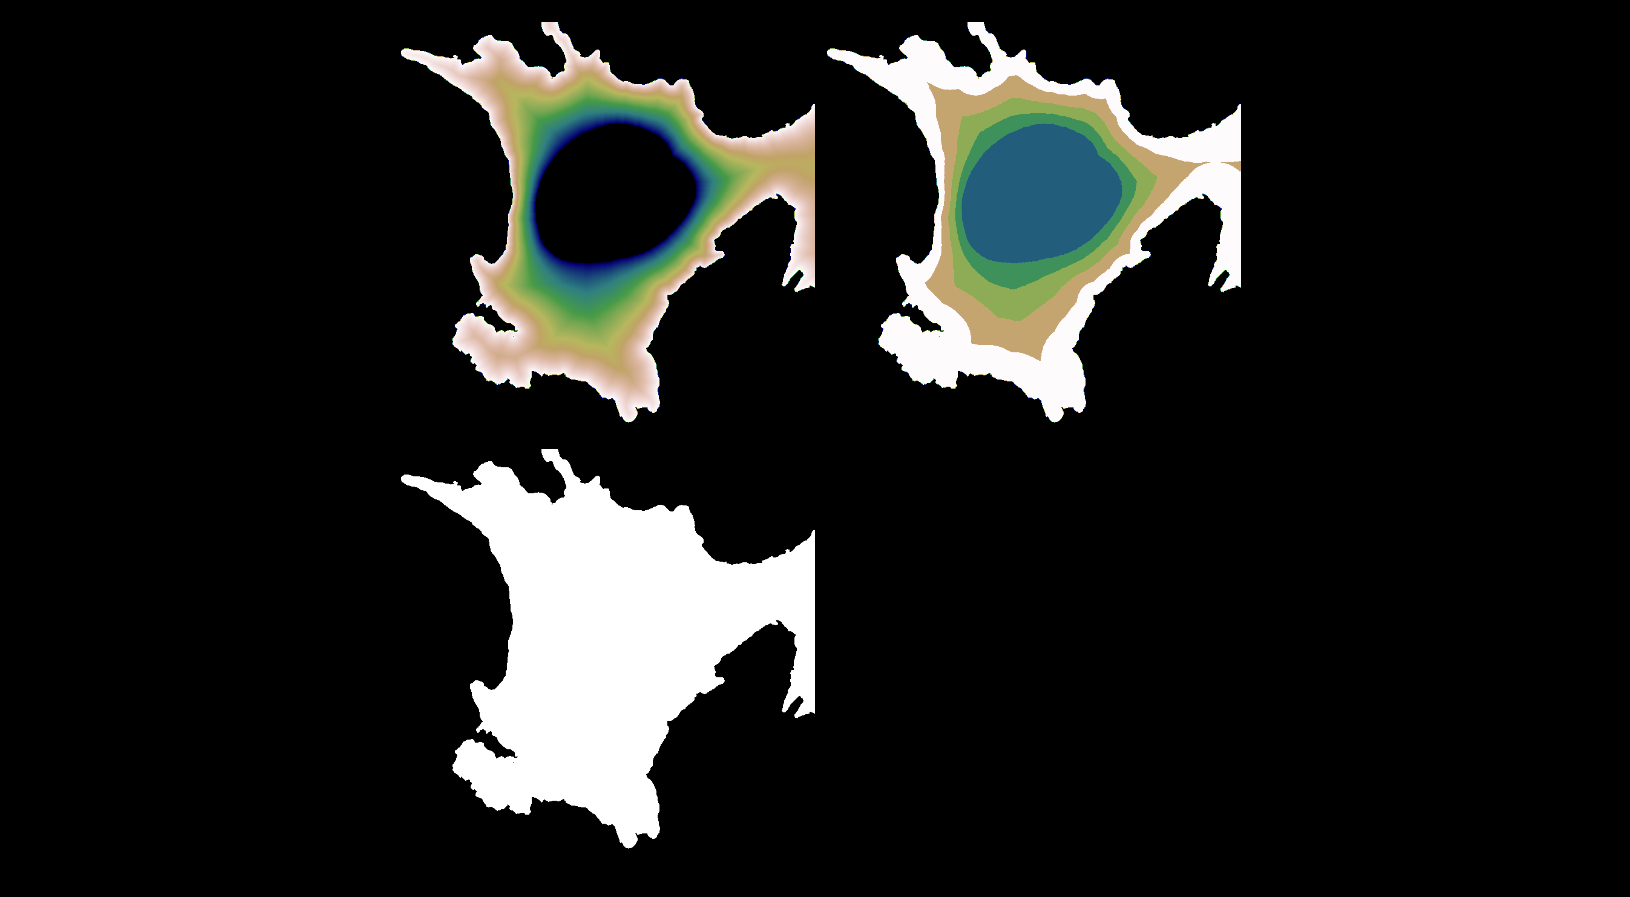

In [157]:
nbscreenshot(viewer_tc, canvas_only= True)

In [158]:
# Establishing names so that the output tables are easy to distingiush
csv_name1 = "no_scale"
csv_name2 = "with_scale"

In [159]:
def test_make_organelle_stat_tables(
    name: str,
    organelle_names: List[str],
    organelles: List[np.ndarray],
    intensities: List[np.ndarray],
    nuclei_obj:np.ndarray, 
    cellmask_obj:np.ndarray,
    organelle_mask: np.ndarray, 
    out_data_path: Path, 
    source_file: str,
    n_rad_bins: Union[int,None] = None,
    n_zernike: Union[int,None] = None,
    keep_nuc_bins: bool = True,
    scale: Union[tuple,None] = None,
) -> int:
    """
    get summary and all cross stats between organelles `a` and `b`
    calls `get_summary_stats_3D`

    """
    count = 0
    org_stats_tabs = []
    for j, target in enumerate(organelle_names):
        org_img = intensities[j]        
        org_obj = _assert_uint16_labels(organelles[j])

        # A_stats_tab, rp = get_simple_stats_3D(A,mask)
        a_stats_tab, rp = nrm_get_summary_stats_3D(org_obj, org_img, organelle_mask,scale=scale)
        a_stats_tab.insert(loc=0,column='organelle',value=target )
        a_stats_tab.insert(loc=0,column='ID',value=source_file.stem )

        # add the touches for all other organelles
        # loop over Bs
        merged_tabs = []
        for i, nmi in enumerate(organelle_names):
            if i != j:
                # get overall stats of intersection
                # print(f"  b = {nmi}")
                count += 1
                # add the list of touches
                b = _assert_uint16_labels(organelles[i])

                ov = []
                b_labs = []
                labs = []
                for idx, lab in enumerate(a_stats_tab["label"]):  # loop over A_objects
                    xyz = tuple(rp[idx].coords.T)
                    cmp_org = b[xyz]
                    
                    # total number of overlapping pixels
                    overlap = sum(cmp_org > 0)
                    # overlap?
                    labs_b = cmp_org[cmp_org > 0]
                    b_js = np.unique(labs_b).tolist()

                    # if overlap > 0:
                    labs.append(lab)
                    ov.append(overlap)
                    b_labs.append(b_js)

                cname = organelle_to_colname[nmi]
                # add organelle B columns to A_stats_tab
                a_stats_tab[f"{cname}_overlap"] = ov
                a_stats_tab[f"{cname}_labels"] = b_labs  # might want to make this easier for parsing later

                #####  2  ###########
                # get cross_stats

                cross_tab = nrm_get_aXb_stats_3D(org_obj, b, organelle_mask, scale=scale) 
                shell_cross_tab = nrm_get_aXb_stats_3D(org_obj, b, organelle_mask, use_shell_a=True, scale=scale)
                            
                # cross_tab["organelle_b"]=nmi
                # shell_cross_tab["organelle_b"]=nmi
                #  Merge cross_tabs and shell_cross_tabs 
                # merged_tab = pd.merge(cross_tab,shell_cross_tab, on="label_")
                merged_tab = pd.concat([cross_tab,shell_cross_tab])
                merged_tab.insert(loc=0,column='organelle_b',value=nmi )

                merged_tabs.append( merged_tab )


        #  Now append the 
        # csv_path = out_data_path / f"{source_file.stem}-{target}_shellX{nmi}-stats.csv"
        # e_stats_tab.to_csv(csv_path)
        # stack these tables for each organelle
        crossed_tab = pd.concat(merged_tabs)
        # csv_path = out_data_path / f"{source_file.stem}-{target}X{nmi}-stats.csv"
        # stats_tab.to_csv(csv_path)
        crossed_tab.insert(loc=0,column='organelle',value=target )
        crossed_tab.insert(loc=0,column='ID',value=source_file.stem )

        # now get radial stats
        rad_stats,z_stats, _ = nrm_get_radial_stats(        
                cellmask_obj,
                organelle_mask,
                org_obj,
                org_img,
                target,
                nuclei_obj,
                n_rad_bins,
                n_zernike,
                keep_nuc_bins=keep_nuc_bins,
                scale=scale)

        d_stats = nrm_get_depth_stats(        
                cellmask_obj,
                organelle_mask,
                org_obj,
                org_img,
                target,
                nuclei_obj,
                scale = scale
                )
      
        proj_stats = pd.merge(rad_stats, z_stats,on=["organelle","mask"])
        proj_stats = pd.merge(proj_stats, d_stats,on=["organelle","mask"])
        proj_stats.insert(loc=0,column='ID',value=source_file.stem )


        # write out files... 
        # org_stats_tabs.append(A_stats_tab)
        csv_path = out_data_path / f"{source_file.stem}-{target}-{name}-stats.csv"
        a_stats_tab.to_csv(csv_path)

        csv_path = out_data_path / f"{source_file.stem}-{target}-{name}-cross-stats.csv"
        crossed_tab.to_csv(csv_path)

        csv_path = out_data_path / f"{source_file.stem}-{target}-{name}-proj-stats.csv"
        proj_stats.to_csv(csv_path)

        count += 1

    print(f"dumped {count}x3 organelle stats ({organelle_names}) csvs")
    return count

# RUN SCALED AND UNSCALED (CONTROL) VERSION OF `make_organelle_stat_tables`

In [160]:
test_make_organelle_stat_tables(
    csv_name1,
    org_names,
    org_masks,
    org_in,
    org_masks[NUC_CH],
    cell_object,
    cell_object,
    out_data_path,
    source_file,
    n_rad_bins,
    n_zernike,
    True
)

dumped 49x3 organelle stats (['nuc', 'lyso', 'mito', 'golgi', 'perox', 'ER', 'LD']) csvs


49

In [161]:
test_make_organelle_stat_tables(
    csv_name2,
    org_names,
    org_masks,
    org_in,
    org_masks[NUC_CH],
    cell_object,
    cell_object,
    out_data_path,
    source_file,
    n_rad_bins,
    n_zernike,
    True,
    scale
)

dumped 49x3 organelle stats (['nuc', 'lyso', 'mito', 'golgi', 'perox', 'ER', 'LD']) csvs


49

# DUMP THE STATS TABLES

In [162]:
def nrm_create_stats_summary(summary_df:pd.DataFrame) -> pd.DataFrame:
    """
    """
    column_names = summary_df.columns

    def frac(x):
        return (x>0).sum()/x.count() 

    math_cols = ['ID', 'mean_intensity',
        'standard_deviation_intensity',
        'min_intensity','max_intensity', 'equivalent_diameter',
        'euler_number', 'extent']
    vol_cols = ['ID','volume']
    overlap_cols = ['ID'] + [col for col in column_names if col.endswith('_overlap')]
    labels_cols = ['ID'] + [col for col in column_names if col.endswith('_labels')]
   
    agg_func_math = ['sum', 'mean', 'median', 'min', 'max', 'std','count']
    agg_func_overlap = ['sum', 'mean', 'median','count',frac]
    agg_func_labels = ['sum']
    agg_func_vol = ['sum', 'mean', 'median', 'min', 'max', 'std', 'var']
    # for scale
    scounter = 0
    scols = []
    for col in summary_df:
        if col.find("scale") != -1:
            scounter+=1
            scols.append(col)

    
        

    math_summary = summarize_by_id( summary_df[math_cols] , agg_func_math)
    
    # label_stats = fix_list_col(summary_df[labels_cols])
    label_summary = summarize_by_id( summary_df[labels_cols] , agg_func_labels)
    overlap_summary = summarize_by_id( summary_df[overlap_cols] ,agg_func_overlap)
    vol_summary = summarize_by_id( summary_df[vol_cols] , agg_func_vol)
    result = pd.concat([math_summary, vol_summary, overlap_summary, label_summary], axis=1)

# for scale again
    if bool(scounter):
        for col in scols:
            result.insert(loc=1,column=f"{col}",value=summary_df[col][0])


    result.insert(loc=0,column="ID",value=result.index)
    result.insert(loc=1,column=f"Scaled",value=bool(scounter))

    return result

In [163]:
def test_summarize_organelle_stats(name: str, out_path: Union[Path,str], int_path: Union[Path,str], 
                              organelle_names: List[str]= ["nuclei","golgi","peroxi"]):
    """  
    """
    # write out files... 

    if isinstance(int_path, str): int_path = Path(int_path)

    if not Path.exists(out_path):
        Path.mkdir(out_path)
        print(f"making {out_path}")

    all_stats_df = pd.DataFrame()
    all_cross_stats_df = pd.DataFrame()
    all_proj_stats_df = pd.DataFrame()
    
    for target in organelle_names:
        stat_file_list = sorted( int_path.glob(f"*{target}-{name}-stats.csv") )

        stats_df = pd.DataFrame()
        cross_stats_df = pd.DataFrame()
        proj_stats_df = pd.DataFrame()

        for stats_f in stat_file_list:
            stem = stats_f.stem.split("-")[0] + "-" + stats_f.stem.split("-")[1]
            # stats load the csv
            stats = load_stats_csv(out_path,stem, f'{target}-{name}')
            # projection stats
            proj = load_proj_stats_csv(out_path,stem, f'{target}-{name}')
            # cross stats
            cross = load_cross_stats_csv(out_path,stem, f'{target}-{name}')

            stats_df = pd.concat([stats_df,stats],axis=0, join='outer')
            proj_stats_df = pd.concat([proj_stats_df,proj],axis=0, join='outer')
            cross_stats_df = pd.concat([cross_stats_df,cross],axis=0, join='outer')
        

        ## maybe merge into all the possible files?
        # summary_df = pd.DataFrame(index=[f.stem.split("-")[0] for f in stat_file_list])
        # cross_stats_df = pd.DataFrame(index=[f.stem.split("-")[0] for f in stat_file_list])
        # proj_stats_df = pd.DataFrame(index=[f.stem.split("-")[0] for f in stat_file_list])

        summary_df = nrm_create_stats_summary(stats_df)
        summary_df.insert(loc=1,column="organelle",value=target)
        cross_summary_df = summarize_cross_stats(cross_stats_df)
        ## cross_summary_df = pivot_cross_stats(cross_stats_df)  #makes a wide version... but has a bug
        cross_summary_df.insert(loc=1,column="organelle",value=target)

        all_stats_df = pd.concat([all_stats_df,summary_df],axis=0)
        all_proj_stats_df = pd.concat([all_proj_stats_df,proj_stats_df],axis=0)
        all_cross_stats_df = pd.concat([all_cross_stats_df,cross_summary_df],axis=0)
    

    return all_stats_df, all_proj_stats_df, all_cross_stats_df
        



In [164]:
def test_dump_organelle_summary_tables(
                    name: str,
                    int_path: Union[Path,str], 
                    out_path: Union[Path, str], 
                    organelle_names: List[str]= ["nuclei","golgi","peroxi"] ) -> int:
    """
    get summary and all cross stats between organelles `a` and `b`
    calls `get_summary_stats_3D`
    """

    if not Path.exists(out_path):
        Path.mkdir(out_path)
        print(f"making {out_path}")


    all_stats_df, all_proj_stats_df, all_cross_stats_df = test_summarize_organelle_stats(name, out_path, int_path, organelle_names)

    csv_path = out_path / f"summary-{name}-stats.csv"
    all_stats_df.to_csv(csv_path)

    csv_path = out_path / f"summary-proj-{name}-stats.csv"
    all_proj_stats_df.to_csv(csv_path)

    csv_path = out_path / f"summary-cross-{name}-stats.csv"
    all_cross_stats_df.to_csv(csv_path)

    return 1

In [165]:
test_dump_organelle_summary_tables(csv_name1,out_data_path,out_data_path,org_names)

1

In [166]:
test_dump_organelle_summary_tables(csv_name2,out_data_path,out_data_path,org_names)

1

# HOW SCALE EFFECTS THE DATA

## INDIVIDUAL ORGANELLE STATS
Scaled

- volume: n * zyx
- equivalent diameter: n * zyx**(1/3)
- centroid-0: n * z
- centroid-1: n * y
- centroid-2: n * x
- surface_area: depends on the shape

Not Scaled

- *offset*
- ID	
- organelle	
- label	
- max_intensity	
- mean_intensity	
- min_intensity	
- bbox (0-5)
- euler_number	
- extent	
- standard_deviation_intensity
- overlap and labels for (NU,LS,MT,GL,ER,LD)


## INDIVIDUAL ORGANELLE CROSS STATS
Scaled

- volume: n * zyx
- equivalent diameter: n * zyx**(1/3)
- centroid-0: n * z
- centroid-1: n * y
- centroid-2: n * x
- surface_area: depends on the shape

Not Scaled

- *offset*
- ID
- organelle
- organelle_b
- shell	
- label_	
- label
- bbox (0-5)
- label_a	
- label_b

## INDIVIDUAL ORGANELLE PROJECTION STATS
Scaled

- radial_cm_vol: n * zyx
- radial_org_vol: n * zyx
- radial_n_area: n * yx
- z_length: n_z * z
- z_cm_area: z_cm_vox * (yx)
- z_org_area: z_org_vox * (yx)

Not Scaled

- index
- ID
- organelle	mask	
- radial_n_bins
- radial_bins	
- radial_cm_vox_cnt	
- radial_org_vox_cnt
- radial_org_intensity	
- radial_n_pix	
- radial_cm_cv	
- radial_org_cv	
- radial_img_cv	
- zernike_n	
- zernike_m	
- zernike_cm_mag	
- zernike_cm_phs	
- zernike_obj_mag	
- zernike_obj_phs	
- zernike_nuc_mag	
- zernike_nuc_phs	
- zernike_img_mag	
- zernike_img_phs	
- n_z	
- z	
- z_cm_vox_cnt	
- z_org_vox_cnt	
- z_org_intensity	
- z_nuc_vox_cnt


# COMPARE / CONTRAST THE DATA

In [167]:
# Allows us to observe all of the columns in the pandas tables
pd.set_option('display.max_columns', None)

First like compare the data on the individual organelle level

In [168]:
print(f"We will first open the data organelle stats from the {organelle_names[ex_org]} file")

We will first open the data organelle stats from the lyso file


This is a modified version to open the scaled or unscaled version

In [169]:
def _load_stats_csv(in_path: Path, 
                    img_id: str, 
                    target_org: str,
                    scale: Union[bool,None] = False) -> pd.DataFrame:
    if scale:
        s = "with_scale"
    else:
        s = "no_scale"
    """ helper to load the basic stats csv: `img_id`-`target_organelle` -stats.csv
    returns pandas DataFrame """
    csv_path = in_path / f"{img_id}-{target_org}-{s}-stats.csv"
    stats = pd.read_csv(csv_path, index_col=0,dtype={"ID":str,"organelle":str})
    # need to convert columns *_labels
    list_cols = [col for col in stats.columns if col.endswith('_labels')]
    stats = fix_int_list_cols(stats,list_cols)
    return stats

In [170]:
individual_stats_ns = _load_stats_csv(out_data_path, test_img_name.stem, org_names[ex_org])
individual_stats_ns[0:5]

,ID,organelle,label,max_intensity,mean_intensity,min_intensity,volume,equivalent_diameter,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,euler_number,extent,standard_deviation_intensity,surface_area,Scaled,NU_overlap,NU_labels,MT_overlap,MT_labels,GL_overlap,GL_labels,PR_overlap,PR_labels,ER_overlap,ER_labels,LD_overlap,LD_labels
0,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,3,5988.0,1850.891139,0.0,395.0,9.103313,4.531646,410.574684,332.926582,2,403,323,8,422,343,1,0.173246,1304.540787,639.654724,No,0,[],0,[],20,[5],0,[],73,[1],0,[]
1,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,4,12116.0,2925.016900,0.0,4438.0,20.389014,5.660433,411.029743,366.106805,2,385,338,10,443,417,0,0.121072,2029.439197,4311.281250,No,0,[],151,[10],325,"[1, 2, 14]",0,[],876,[1],0,[]
2,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,5,6757.0,1639.304348,0.0,161.0,6.749564,2.496894,428.173913,688.397516,2,424,681,4,434,698,1,0.473529,1185.364593,299.380859,No,0,[],0,[],0,[],0,[],27,[1],0,[]
3,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,6,13291.0,3647.003264,0.0,1532.0,14.302766,9.736292,577.416449,170.502611,4,563,151,16,599,189,2,0.093324,2108.309950,1789.977905,No,0,[],0,[],0,[],0,[],0,[],52,"[37, 39]"
4,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,8,8232.0,1985.434109,0.0,129.0,6.268982,2.434109,651.813953,394.201550,2,646,391,4,657,399,1,0.732955,1450.401948,227.135330,No,0,[],0,[],0,[],0,[],0,[],0,[]


In [171]:
individual_stats_s = _load_stats_csv(out_data_path, test_img_name.stem, org_names[ex_org], True)
individual_stats_s[0:5]

,ID,organelle,label,max_intensity,mean_intensity,min_intensity,volume,equivalent_diameter,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,euler_number,extent,standard_deviation_intensity,surface_area,Scaled,scale_dim0,scale_dim1,scale_dim2,NU_overlap,NU_labels,MT_overlap,MT_labels,GL_overlap,GL_labels,PR_overlap,PR_labels,ER_overlap,ER_labels,LD_overlap,LD_labels
0,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,3,5988.0,1850.891139,0.0,0.980538,1.232599,1.763347,32.793278,26.591396,2,403,323,8,422,343,1,0.173246,1304.540787,10.758176,Yes,0.389118,0.079872,0.079872,0,[],0,[],20,[5],0,[],73,[1],0,[]
1,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,4,12116.0,2925.016900,0.0,11.016775,2.760696,2.202579,32.829625,29.241555,2,385,338,10,443,417,0,0.121072,2029.439197,60.086503,Yes,0.389118,0.079872,0.079872,0,[],151,[10],325,"[1, 2, 14]",0,[],876,[1],0,[]
2,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,5,6757.0,1639.304348,0.0,0.399662,0.913899,0.971588,34.198958,54.983447,2,424,681,4,434,698,1,0.473529,1185.364593,4.997658,Yes,0.389118,0.079872,0.079872,0,[],0,[],0,[],0,[],27,[1],0,[]
3,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,6,13291.0,3647.003264,0.0,3.802997,1.936611,3.788571,46.119206,13.618325,4,563,151,16,599,189,2,0.093324,2108.309950,29.048235,Yes,0.389118,0.079872,0.079872,0,[],0,[],0,[],0,[],0,[],52,"[37, 39]"
4,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,8,8232.0,1985.434109,0.0,0.320226,0.848827,0.947157,52.061457,31.485529,2,646,391,4,657,399,1,0.732955,1450.401948,3.675328,Yes,0.389118,0.079872,0.079872,0,[],0,[],0,[],0,[],0,[],0,[]


The Volume should be scaled by the product of the scale in microns cubed, lets see if this is the case.

In [172]:
comp1 = {"ID": individual_stats_ns["ID"],
         "Organelle": individual_stats_ns["organelle"],
         "Volume Mean Pre Scale": individual_stats_ns["volume"].round(2),
         "Volume times zyx product": (individual_stats_ns["volume"] * np.prod(scale)).round(2),
         "Volume Mean Post Scale": individual_stats_s["volume"].round(2),
         "Equal": (individual_stats_ns["volume"] * np.prod(scale)).round(2) == individual_stats_s["volume"].round(2)}

pd.DataFrame(comp1)[0:10]

,ID,Organelle,Volume Mean Pre Scale,Volume times zyx product,Volume Mean Post Scale,Equal
0,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,395.0,0.98,0.98,True
1,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,4438.0,11.02,11.02,True
2,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,161.0,0.40,0.40,True
3,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,1532.0,3.80,3.80,True
4,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,129.0,0.32,0.32,True
5,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,94.0,0.23,0.23,True
6,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,72.0,0.18,0.18,True
7,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,32.0,0.08,0.08,True
8,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,168.0,0.42,0.42,True
9,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,39.0,0.10,0.10,True


The equivalent diameter should be scaled by the cubed root of the scale

In [173]:
comp2 = {"ID": individual_stats_ns["ID"],
         "Organelle": individual_stats_ns["organelle"],
         "Equivalent Diameter Pre Scale": individual_stats_ns["equivalent_diameter"].round(2),
         "Equiv Diameter times cubed root of zyx product": (individual_stats_ns["equivalent_diameter"] * np.prod(scale)**(1/3)).round(2),
         "Equiv Diameter Post Scale": individual_stats_s["equivalent_diameter"].round(2),
         "Equal": (individual_stats_ns["equivalent_diameter"] * np.prod(scale)**(1/3)).round(2) == individual_stats_s["equivalent_diameter"].round(2)}

pd.DataFrame(comp2)[0:10]

,ID,Organelle,Equivalent Diameter Pre Scale,Equiv Diameter times cubed root of zyx product,Equiv Diameter Post Scale,Equal
0,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,9.10,1.23,1.23,True
1,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,20.39,2.76,2.76,True
2,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,6.75,0.91,0.91,True
3,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,14.30,1.94,1.94,True
4,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,6.27,0.85,0.85,True
5,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,5.64,0.76,0.76,True
6,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,5.16,0.70,0.70,True
7,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,3.94,0.53,0.53,True
8,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,6.85,0.93,0.93,True
9,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,4.21,0.57,0.57,True


Because the surface area is based on a mesh estimate of the object, how much the surface area is scaled depends on the shape of the object.

In [174]:
comp3 = {"ID": individual_stats_ns["ID"],
         "Organelle": individual_stats_ns["organelle"],
         "Surface Area": individual_stats_ns["surface_area"].round(2),
         "Surface Area Post Scale": individual_stats_s["surface_area"].round(2)}

pd.DataFrame(comp3)[0:10]

,ID,Organelle,Surface Area,Surface Area Post Scale
0,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,639.65,10.76
1,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,4311.28,60.09
2,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,299.38,5.00
3,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,1789.98,29.05
4,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,227.14,3.68
5,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,206.80,3.64
6,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,152.65,2.67
7,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,103.27,1.69
8,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,261.45,4.56
9,24hrs-Ctrl +oleicAcid 50uM_3_Unmixing,lyso,119.65,1.84


The rest of the of the measurments are scaled quite simply, so observing the important ones in sufficient. Overall the new regionprops argument "spacing" allows for the interpretation of our data that will allow us not only to publish meaningful findings, but also opens the door for new meaningful measurements.